In [1]:
import pandas as pd
path = "./archive/stemmed_cleaned_data.csv"

df = pd.read_csv(path, delimiter=",", quotechar='"')

print(df.head())

                              title  \
0               Mental Note Vol. 24   
1         Your Brain On Coronavirus   
2                    Mind Your Nose   
3          The 4 Purposes of Dreams   
4  Surviving a Rod Through the Head   

                                                text  \
0  Photo by Josh Riemer on Unsplash\n\nMerry Chri...   
1  Your Brain On Coronavirus\n\nA guide to the cu...   
2  Mind Your Nose\n\nHow smell training can chang...   
3  Passionate about the synergy between science a...   
4  You’ve heard of him, haven’t you? Phineas Gage...   

                                                 url                 authors  \
0  https://medium.com/invisible-illness/mental-no...            ['Ryan Fan']   
1  https://medium.com/age-of-awareness/how-the-pa...       ['Simon Spichak']   
2  https://medium.com/neodotlife/mind-your-nose-f...                      []   
3  https://medium.com/science-for-real/the-4-purp...  ['Eshan Samaranayake']   
4  https://medium.com/live-y

In [2]:
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer

# Prétraitement : Suppression des NaN et Transformation TF-IDF
tags = [
    "Blockchain", "Data Science", "Technology", "Programming", "Poetry",
    "Cryptocurrency", "Machine Learning", "Life", "Bitcoin", "Writing",
    "Politics", "Startup", "Life Lessons", "Self Improvement", "Covid 19",
    "Software Development", "Love", "Python", "Business", "Health",
    "Mental Health", "JavaScript", "Relationships", "Education",
    "Artificial Intelligence", "Culture", "Design", "Self", "Marketing",
    "Entrepreneurship", "Ethereum", "Music", "Productivity",
    "Web Development", "History", "Humor", "Data Visualization",
    "Leadership", "Social Media", "Psychology", "Travel", "Fiction",
    "Creativity", "Coronavirus", "Parenting", "Crypto", "Science",
    "Tech", "UX", "Short Story"
]

tag_groups = {
    "Blockchain": "Crypto",
    "Bitcoin": "Crypto",
    "Cryptocurrency": "Crypto",
    "Ethereum": "Crypto",
    "Tech": "Technology",
    "Programming": "Technology",
    "Software Development": "Technology",
    "Python": "Technology",
    "JavaScript": "Technology",
    "Web Development": "Technology",
    "Data Science": "AI & Data",
    "Machine Learning": "AI & Data",
    "Artificial Intelligence": "AI & Data",
    "Data Visualization": "AI & Data",
    "Startup": "Business",
    "Entrepreneurship": "Business",
    "Marketing": "Business",
    "Business": "Business",
    "Health": "Wellness",
    "Mental Health": "Wellness",
    "Self Improvement": "Wellness",
    "Life Lessons": "Wellness",
}

# Liste des 20 premiers tags
top_20_tags = tags[:20].copy()

#On ne garde que les article qui possent un des 20 tags séléctionnés

df['tags'] = df['tags'].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)

# Filtrer le DataFrame pour ne garder que les articles avec ces tags
df = df[df['tags'].apply(lambda tags: any(tag in top_20_tags for tag in tags))].copy()

# On ne garde que le premier tag pour chaque article
df['main_tag'] = df['tags'].apply(lambda tags: next((tag for tag in tags if tag in top_20_tags), None))

# Appliquer les regroupements
df['main_tag'] = df['main_tag'].apply(lambda x: tag_groups.get(x, x))

# Supprime les lignes avec clean_text vide
df = df.dropna(subset=['clean_text'])  

print(df)

df_sample = df.sample(10000)
#tf-idf
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df_sample['clean_text'])

                                                    title  \
0                                     Mental Note Vol. 24   
3                                The 4 Purposes of Dreams   
4                        Surviving a Rod Through the Head   
5       Mentally, Young Adults Are Suffering Most From...   
6       How to Turn Your Popular Blog Series Into a Be...   
...                                                   ...   
192333  [Live Stream] 2021 Soul Train Music Awards | F...   
192336  The global startup festival “COMEUP 2021” begi...   
192340  How To Deal with Loneliness in Festivals & Exp...   
192342                        Type 2 Diabetes on the Rise   
192343  The Concept of Stem Cells. Have you ever wonde...   

                                                     text  \
0       Photo by Josh Riemer on Unsplash\n\nMerry Chri...   
3       Passionate about the synergy between science a...   
4       You’ve heard of him, haven’t you? Phineas Gage...   
5       Mentally, Young

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np

#Réduction de Dimension avec LDA (LDA nécessite y catégorique)
y = df_sample['main_tag'].astype('category').cat.codes  # Encodage des classes
lda = LDA(n_components=min(len(np.unique(y))-1, 19))  # LDA limité à nb_classes-1
X_lda = lda.fit_transform(X_tfidf.toarray(), y)

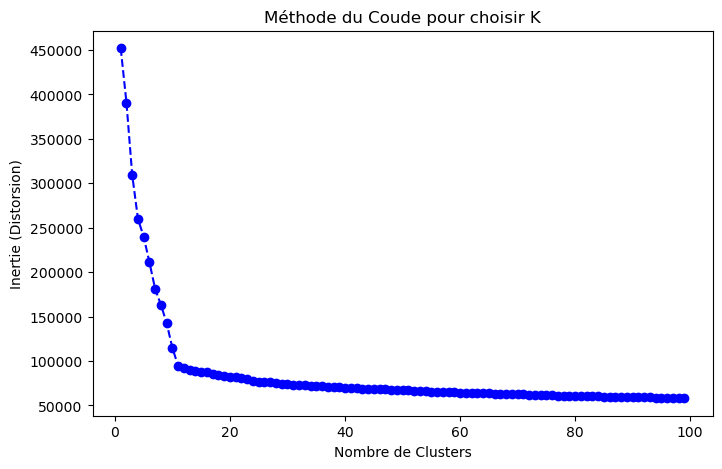

In [4]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
os.environ["OMP_NUM_THREADS"] = "4"  # Limiter à 4 threads
from sklearn.cluster import KMeans

#Méthode du coude pour trouver le nombre de cluster optimisé

# Appliquer K-Means pour plusieurs valeurs de k
distortions = []

for k in range(1, 100):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_lda)
    distortions.append(kmeans.inertia_)  # Inertie = somme des distances au centre

# Tracer la courbe d'inertie
plt.figure(figsize=(8, 5))
plt.plot(range(1, 100), distortions, marker='o', linestyle='--', color='b')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inertie (Distorsion)')
plt.title("Méthode du Coude pour choisir K")
plt.show()


Nombre optimal de clusters : 11


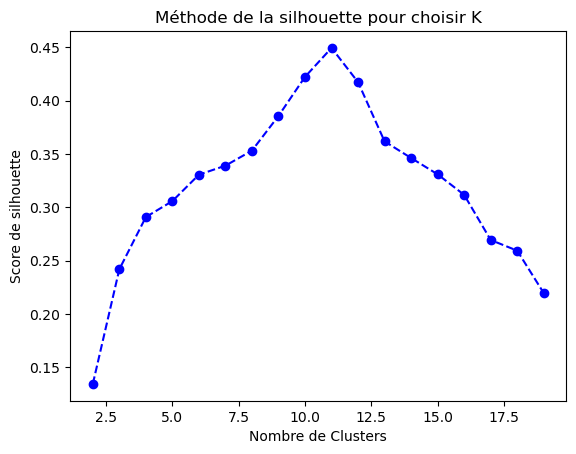

In [5]:
from sklearn.metrics import silhouette_score
silhouette_scores = []

#méthode silhouette de 2 à 20 car réduit grâce à la méthode du coude
for k in range(2, 20):  # On teste plusieurs valeurs de k
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_lda)
    score = silhouette_score(X_lda, labels)
    silhouette_scores.append(score)

# Trouver le k optimal
optimal_k = np.argmax(silhouette_scores) + 2  # +2 car on commence à k=2
print(f"Nombre optimal de clusters : {optimal_k}")

plt.plot(range(2, 20), silhouette_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Score de silhouette')
plt.title("Méthode de la silhouette pour choisir K")
plt.show()

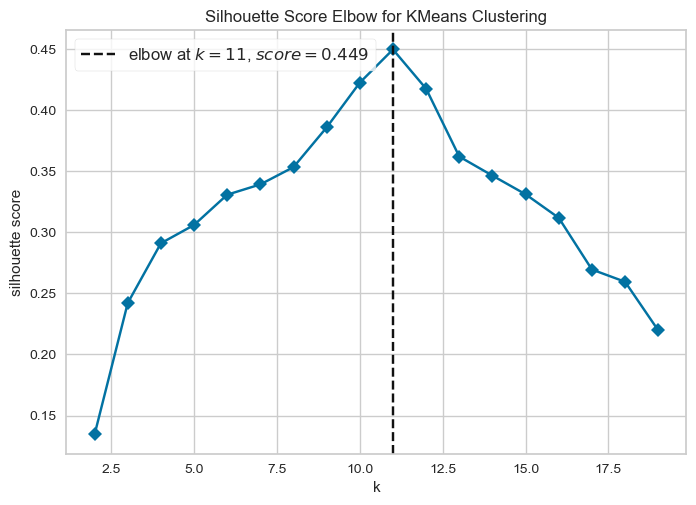

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [6]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 20), metric='silhouette', timings=False)

visualizer.fit(X_lda)
visualizer.show()

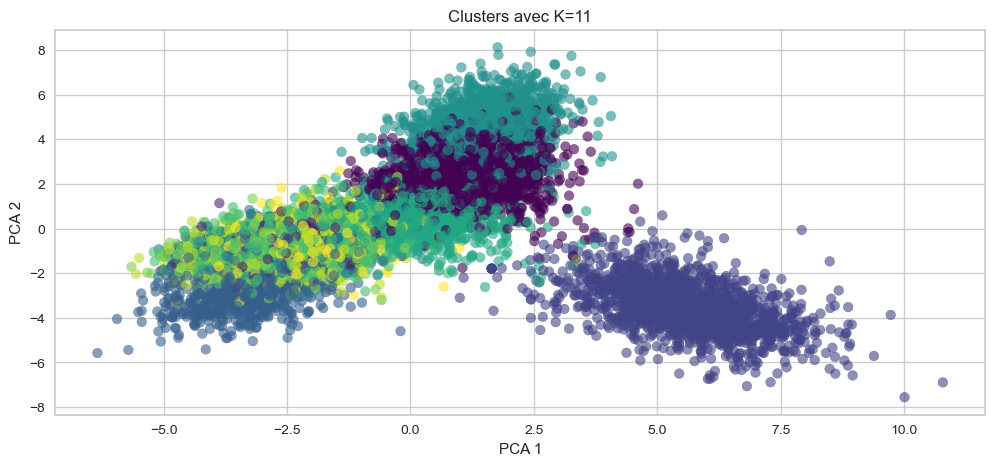

In [7]:
# Réduire à 2 dimensions avec PCA
pca_2d = LDA(n_components=2)
X_2d = pca_2d.fit_transform(X_lda, y)

#Application des algorithmes de clustering avec 10 components
kmeans_10 = KMeans(n_clusters=11, random_state=42)
labels_10 = kmeans_10.fit_predict(X_lda)

plt.figure(figsize=(12, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_10, cmap='viridis', alpha=0.6)
plt.title("Clusters avec K=11")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.show()

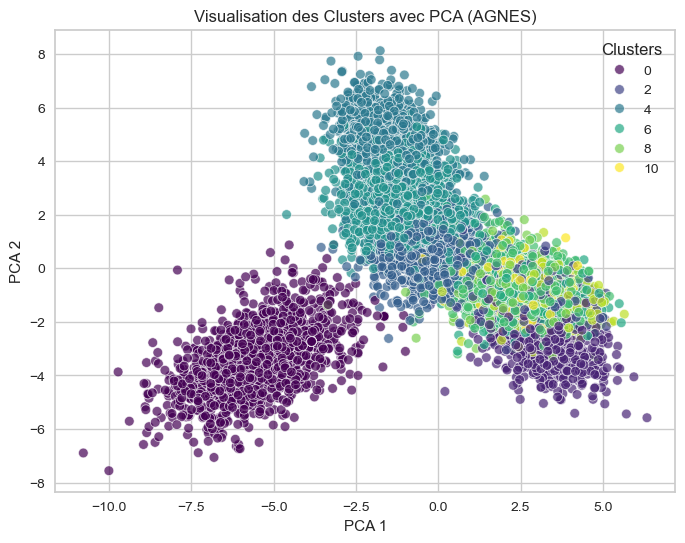

In [8]:
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

# Appliquer AGNES (Agglomerative Clustering)
agnes = AgglomerativeClustering(n_clusters=11, linkage='ward')  # 'ward' minimise la variance intra-cluster
clusters_agnes = agnes.fit_predict(X_lda)

# Tracer les clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=clusters_agnes, palette="viridis", alpha=0.7)
plt.title("Visualisation des Clusters avec PCA (AGNES)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Clusters")
plt.show()

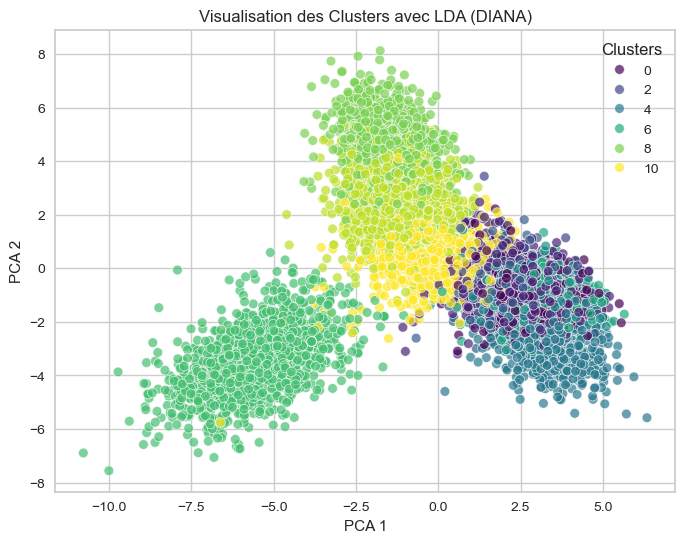

In [20]:
from sklearn.cluster import BisectingKMeans

# Appliquer une approche DIANA via Bisecting K-Means
diana = BisectingKMeans(n_clusters=11, random_state=42)
clusters_diana = diana.fit_predict(X_lda)

# Tracer les clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=clusters_diana, palette="viridis", alpha=0.7)
plt.title("Visualisation des Clusters avec LDA (DIANA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Clusters")
plt.show()

In [12]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Plage de valeurs à tester
eps_values = np.linspace(0.1, 2, 10)  # Tester de 0.1 à 2 par pas de 0.2
min_samples_values = range(5, 30, 5)  # Tester de 5 à 30 par pas de 5

best_score = -1
best_params = None
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        # Appliquer DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_lda)

        # Filtrer les points qui ne sont pas des outliers (-1)
        valid_clusters = clusters[clusters != -1]
        valid_X = X_lda[clusters != -1]

        # Vérifier qu'on a au moins 2 clusters valides pour calculer silhouette score
        if len(set(valid_clusters)) > 1:
            silhouette = silhouette_score(valid_X, valid_clusters)
            davies_bouldin = davies_bouldin_score(valid_X, valid_clusters)

            # Stocker les résultats
            results.append((eps, min_samples, silhouette, davies_bouldin))

            # Garder la meilleure config selon Silhouette Score
            if silhouette > best_score:
                best_score = silhouette
                best_params = (eps, min_samples)

# Trier les résultats par Silhouette Score décroissant
results.sort(key=lambda x: x[2], reverse=True)

# Afficher les 5 meilleures configurations
print("Top 5 des meilleures configurations DBSCAN :")
print("EPS\tMin Samples\tSilhouette\tDavies-Bouldin")
for res in results[:5]:
    print(f"{res[0]:.2f}\t{res[1]}\t\t{res[2]:.3f}\t\t{res[3]:.3f}")

# Afficher les meilleurs paramètres
print(f"\n✅ Meilleur DBSCAN trouvé : eps={best_params[0]:.2f}, min_samples={best_params[1]}")

Top 5 des meilleures configurations DBSCAN :
EPS	Min Samples	Silhouette	Davies-Bouldin
0.10	15		1.000		0.000
0.31	15		1.000		0.000
0.52	15		1.000		0.000
0.73	15		1.000		0.000
0.94	15		1.000		0.000

✅ Meilleur DBSCAN trouvé : eps=0.10, min_samples=15


eps =  2.0
min_samples =  25


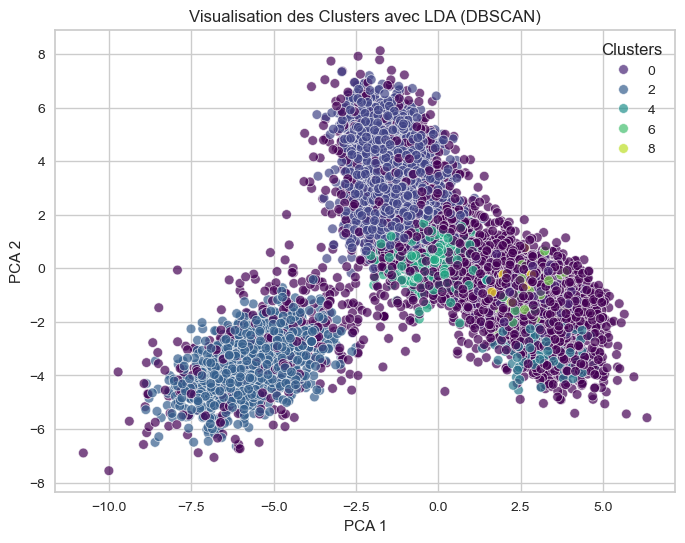

In [19]:
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters_dbscan = dbscan.fit_predict(X_lda)

# Tracer les clusters
print("eps = ", eps)
print("min_samples = ", min_samples)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=clusters_dbscan, palette="viridis", alpha=0.7)
plt.title("Visualisation des Clusters avec LDA (DBSCAN)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Clusters")
plt.show()

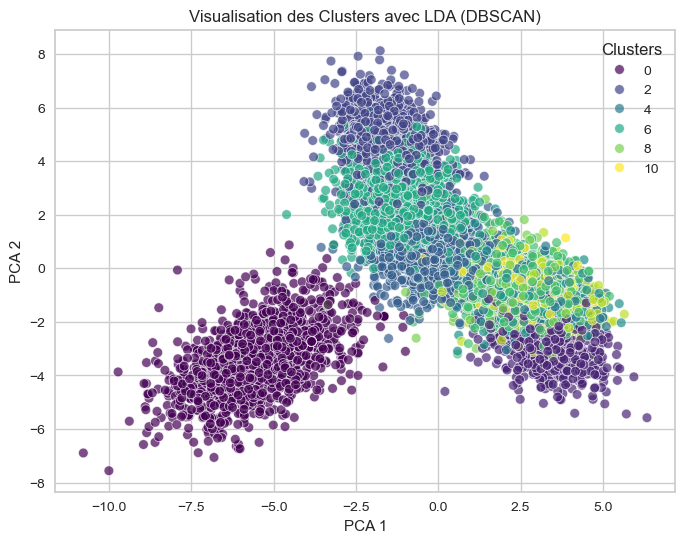

In [21]:
from sklearn.cluster import Birch

# Appliquer BIRCH
birch = Birch(n_clusters=11)  # Ajuster n_clusters selon les besoins
clusters_birch = birch.fit_predict(X_lda)

# Tracer les clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=clusters_birch, palette="viridis", alpha=0.7)
plt.title("Visualisation des Clusters avec LDA (DBSCAN)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Clusters")
plt.show()

c:\Users\bapti\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:1086: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


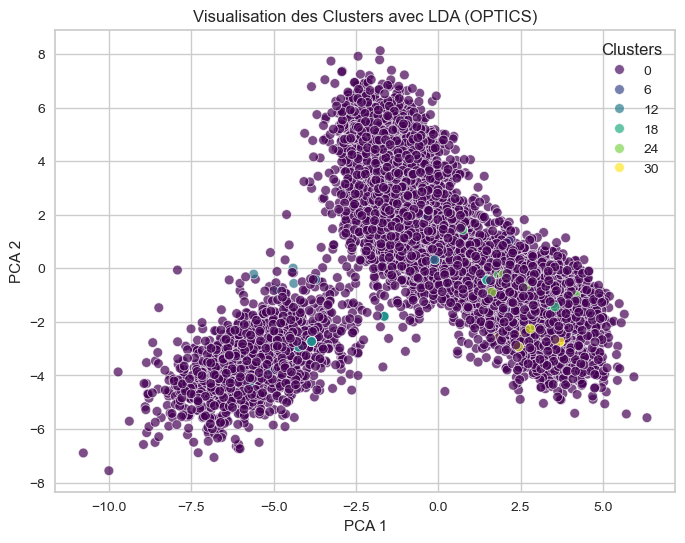

In [43]:
from sklearn.cluster import OPTICS

# Appliquer OPTICS
optics = OPTICS(min_samples=5)  # Ajuster min_samples si nécessaire
clusters_optics = optics.fit_predict(X_lda)

# Tracer les clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=clusters_optics, palette="viridis", alpha=0.7)
plt.title("Visualisation des Clusters avec LDA (OPTICS)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Clusters")
plt.show()

bandwidth = 0.10 | Silhouette Score = 0.0206
bandwidth = 0.31 | Silhouette Score = 0.0209
bandwidth = 0.52 | Silhouette Score = 0.0210
bandwidth = 0.73 | Silhouette Score = 0.0221
bandwidth = 0.94 | Silhouette Score = 0.0269
bandwidth = 1.16 | Silhouette Score = 0.0350
bandwidth = 1.37 | Silhouette Score = 0.0350
bandwidth = 1.58 | Silhouette Score = 0.0265
bandwidth = 1.79 | Silhouette Score = 0.0088
bandwidth = 2.00 | Silhouette Score = -0.0146

Meilleur bandwidth: 1.16 avec un Silhouette Score de 0.0350


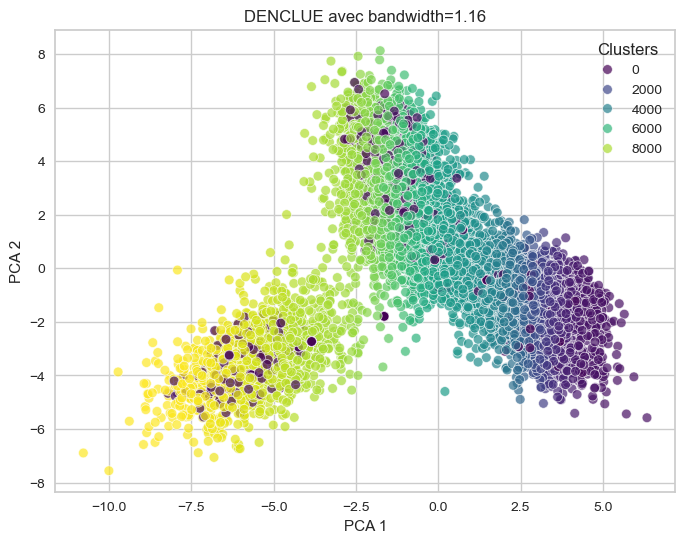

In [27]:
from sklearn.cluster import MeanShift
from sklearn.neighbors import KernelDensity

# Définir une plage de valeurs pour le bandwidth
bandwidth_values = np.linspace(0.1, 2.0, 10)  # Ajuste les bornes si besoin

best_score = -1
best_bandwidth = None
best_labels = None

# Tester plusieurs valeurs de bandwidth
for bandwidth in bandwidth_values:
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(X_lda)
    
    mean_shift = MeanShift(bandwidth=bandwidth)
    labels = mean_shift.fit_predict(X_lda)

    # Vérifier s'il y a plusieurs clusters pour calculer le score de silhouette
    if len(set(labels)) > 1:  
        silhouette = silhouette_score(X_lda, labels)
        
        print(f"bandwidth = {bandwidth:.2f} | Silhouette Score = {silhouette:.4f}")

        # Stocker la meilleure configuration
        if silhouette > best_score:
            best_score = silhouette
            best_bandwidth = bandwidth
            best_labels = labels

print(f"\nMeilleur bandwidth: {best_bandwidth:.2f} avec un Silhouette Score de {best_score:.4f}")

# Visualisation du meilleur clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=best_labels, palette="viridis", alpha=0.7)
plt.title(f"DENCLUE avec bandwidth={best_bandwidth:.2f}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Clusters")
plt.show()

Bandwidth estimé pour WaveCluster : 7.64
Score de silhouette : 0.2679


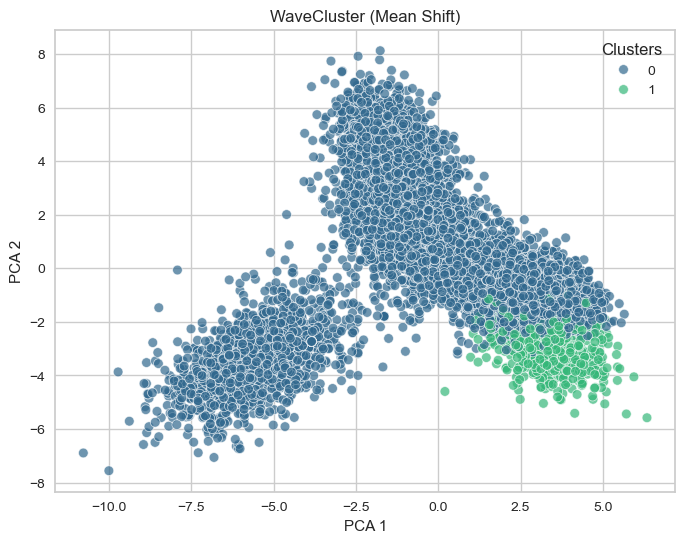

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Estimer un bon bandwidth pour Mean Shift (équivalent à la résolution de WaveCluster)
bandwidth = estimate_bandwidth(X_lda, quantile=0.2, n_samples=500)
print(f"Bandwidth estimé pour WaveCluster : {bandwidth:.2f}")

# Appliquer Mean Shift
wavecluster = MeanShift(bandwidth=bandwidth)
labels_wave = wavecluster.fit_predict(X_lda)

# Score silhouette
if len(set(labels_wave)) > 1:  
    silhouette = silhouette_score(X_lda, labels_wave)
    print(f"Score de silhouette : {silhouette:.4f}")

# Visualisation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=labels_wave, palette="viridis", alpha=0.7)
plt.title("WaveCluster (Mean Shift)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Clusters")
plt.show()

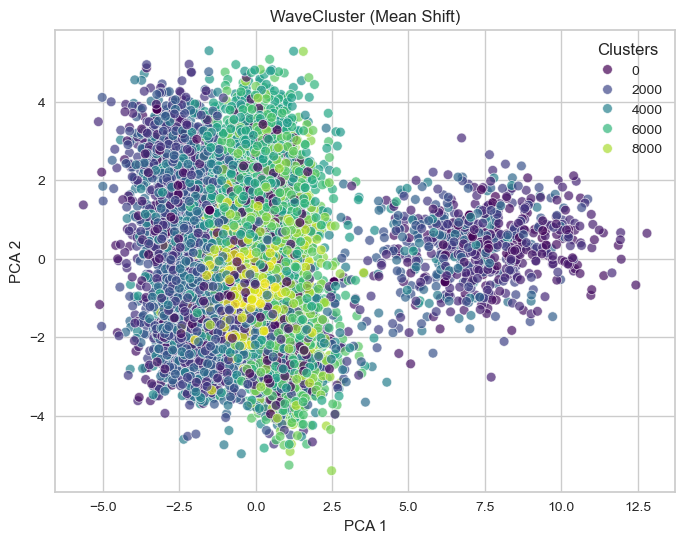

In [82]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lda[:, 2], y=X_lda[:, 5], hue=best_labels, palette="viridis", alpha=0.7)
plt.title("WaveCluster (Mean Shift)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Clusters")
plt.show()

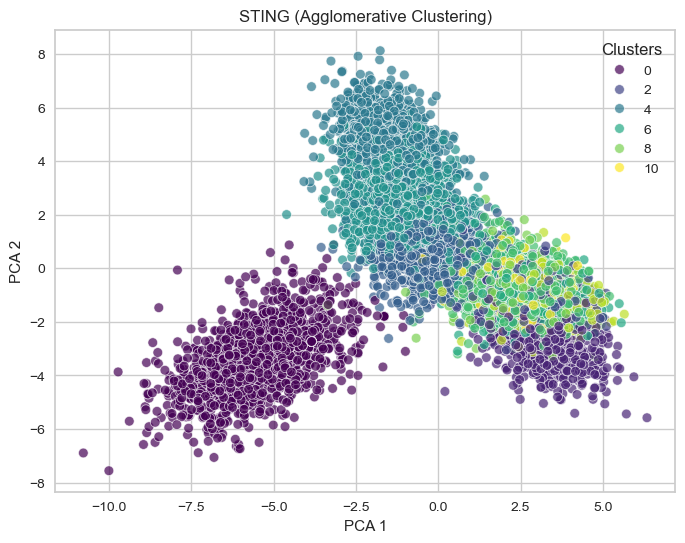

In [42]:
from sklearn.cluster import AgglomerativeClustering

# Appliquer une méthode hiérarchique similaire à STING
sting = AgglomerativeClustering(n_clusters=11, linkage="ward")  
labels_sting = sting.fit_predict(X_lda)

# Visualisation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=labels_sting, palette="viridis", alpha=0.7)
plt.title("STING (Agglomerative Clustering)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Clusters")
plt.show()

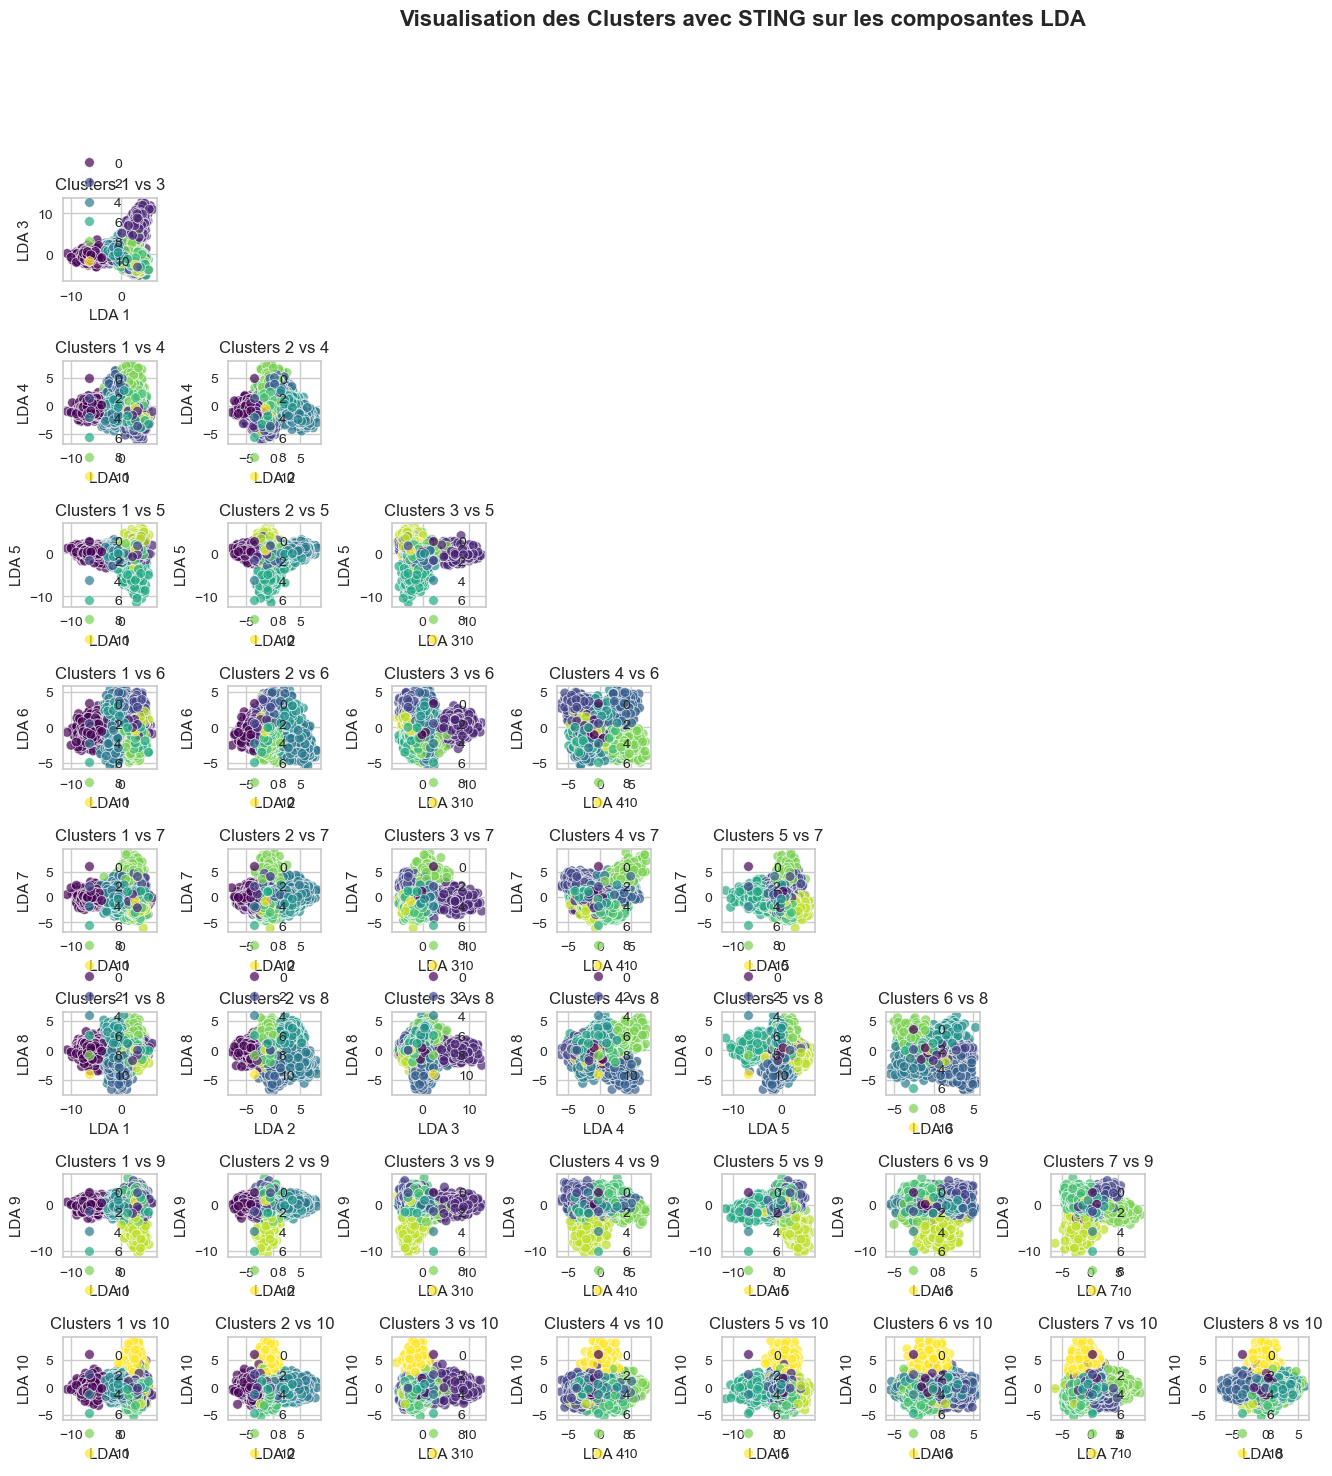

In [96]:
num_components = 10  # Réduire pour améliorer la lisibilité

fig, axes = plt.subplots(num_components - 1, num_components - 1, figsize=(15, 15))
fig.suptitle("Visualisation des Clusters avec STING sur les composantes LDA", fontsize=16, fontweight="bold")

# Boucle pour tracer uniquement la moitié inférieure
for i in range(1, num_components):
    for j in range(i):
        ax = axes[i-1, j]  # Sélectionner le bon sous-graphique
        sns.scatterplot(x=X_lda[:, j], y=X_lda[:, i], hue=labels_sting, palette="viridis", alpha=0.7, ax=ax)
        ax.set_xlabel(f"LDA {j+1}")
        ax.set_ylabel(f"LDA {i+1}")
        ax.set_title(f"Clusters {j+1} vs {i+1}")

# Supprimer les sous-graphiques inutiles
for i in range(num_components - 1):
    for j in range(i, num_components - 1):
        fig.delaxes(axes[i, j])  # Supprime les cases vides

plt.tight_layout()
plt.show()

In [38]:
# Création d'un Dataframe pour les clusters
df_cluster = pd.DataFrame()

# Ajouter les résultats au DataFrame
df_cluster["Cluster_AGNES"] = clusters_agnes
df_cluster["Cluster_Birch"] = clusters_birch
df_cluster["Cluster_Dbscan"] = clusters_dbscan
df_cluster["Cluster_diana"] = clusters_diana
df_cluster["Cluster_optics"] = clusters_optics

print("cluster agnès : \n",df_cluster[ "Cluster_AGNES"].value_counts())
print("\ncluster birch : \n",df_cluster[ "Cluster_Birch"].value_counts())

cluster agnès : 
 5     1863
0     1520
7     1253
4     1116
3      899
2      755
1      678
6      642
8      472
10     447
9      355
Name: Cluster_AGNES, dtype: int64

cluster birch : 
 6     1805
0     1521
7     1275
2     1132
3      922
4      752
1      676
5      642
8      483
10     437
9      355
Name: Cluster_Birch, dtype: int64


In [39]:
print("\ncluster dbscan : \n",df_cluster[ "Cluster_Dbscan"].value_counts())
print("\ncluster diana : \n",df_cluster[ "Cluster_diana"].value_counts())


cluster dbscan : 
 -1    4860
 1    2423
 2    1171
 0     573
 5     364
 3     198
 7     189
 4      75
 6      69
 9      51
 8      27
Name: Cluster_Dbscan, dtype: int64

cluster diana : 
 9     1807
7     1495
1     1258
8     1156
10     966
5      852
4      672
0      603
3      451
2      394
6      346
Name: Cluster_diana, dtype: int64


In [40]:
print("\ncluster optics : \n",df_cluster[ "Cluster_optics"].value_counts())


cluster optics : 
 -1     9725
 16      70
 14      19
 3       12
 20      11
 24      10
 10      10
 28       9
 19       8
 8        7
 22       7
 0        6
 25       6
 27       6
 2        6
 23       6
 26       6
 9        6
 29       5
 5        5
 17       5
 1        5
 7        5
 13       5
 4        5
 12       5
 11       5
 21       5
 6        5
 15       5
 18       5
 30       5
Name: Cluster_optics, dtype: int64
